# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, Camera calibration using chessboard images

In [1]:
# Detect corners and draw them
import os
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline       
# matplotlib inline is necessary to output an image in Jupyter notebook

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
list_image=os.listdir('camera_cal/')
#images = glob.glob('camera_cal/calibration*.jpg')

#Output directory 
Output_dir_Corners='output_images/FindCorners'

# Step through the list and search for chessboard corners
for fname in list_image:
    img = mpimg.imread('camera_cal/' +fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

    # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imwrite(os.path.join(Output_dir_Corners,fname),cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [3]:
pickle.dump(objpoints, open( "objpoints.p", "wb" ))
pickle.dump(imgpoints, open( "imgpoints.p", "wb" ))

## Undistort Images

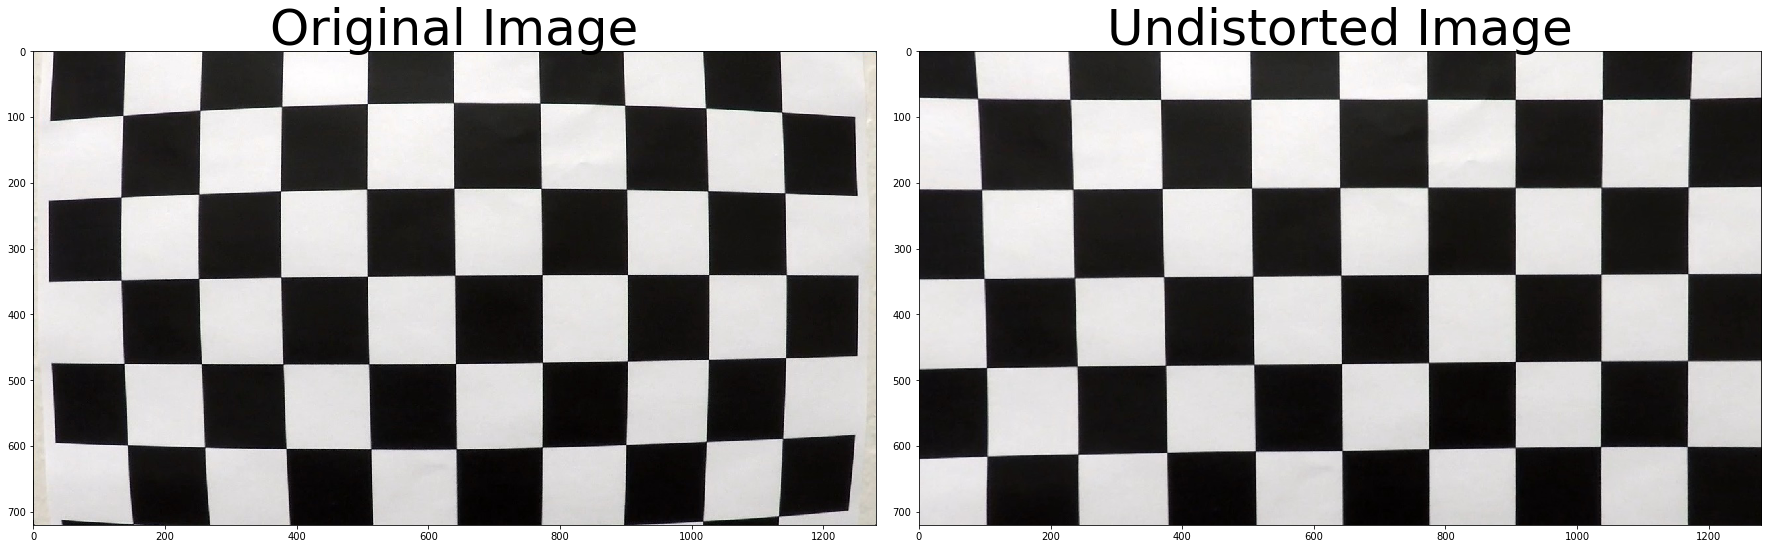

In [4]:
# Camera coefficient distortion and undistort it
#Output directory 
Output_dir_undistorted='output_images/Undistorted'

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
#    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

for fname in list_image:
    img = mpimg.imread('camera_cal/' + fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    cv2.imwrite(os.path.join(Output_dir_undistorted,fname),cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))

##### Exemple
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Distortion correction to raw images.

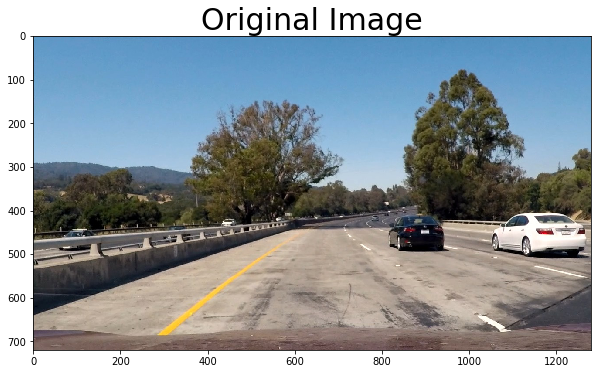

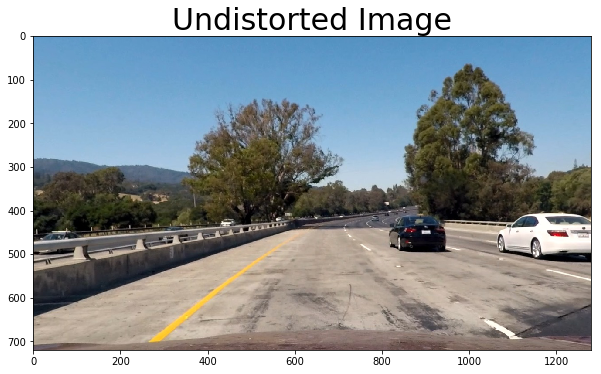

In [5]:
##### Exemple
img = mpimg.imread('test_images/test1.jpg')
plt.figure(figsize=(10,10))
plt.title('Original Image', fontsize=30)
plt.imshow(img)

img = mpimg.imread('test_images/test1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
plt.figure(figsize=(10,10))
plt.title('Undistorted Image', fontsize=30)
plt.imshow(undistorted)

# Make a list of test images
list_image_test=os.listdir('test_images/')
#images_test = glob.glob('test_images/test*.jpg')
#Output directory 
Output_dir_Raw='output_images/Raw'

for fname in list_image_test:
    img = mpimg.imread('test_images/'+ fname)
    undistorted = cal_undistort(img, objpoints, imgpoints)
    cv2.imwrite(os.path.join(Output_dir_Raw,fname),cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))    

## Color transforms, gradients, etc., to create a thresholded binary image.

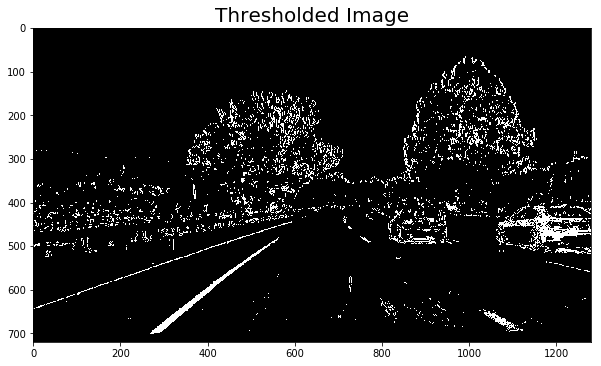

In [6]:
# Note: img is the undistorted image

def S_and_Sx_threshold(img,s_thresh=[0,255],sx_thresh=[0,255],sobel_kernel=3):

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Grayscale image
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = sx_thresh[0]
    thresh_max = sx_thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

## Parameters 
S_min_max=[190,255]
Sx_min_max=[30,80]
sobel_kernel=5

#Diretory of the undistorted image
list_image_Raw=os.listdir("output_images/Raw/")
Output_dir_Threshold=('output_images/Thresholded')

for fname in list_image_Raw[:8]:
    img = mpimg.imread('output_images/Raw/' + fname)
    Threshold=S_and_Sx_threshold(img,S_min_max,Sx_min_max,sobel_kernel)
    cv2.imwrite(os.path.join(Output_dir_Threshold,fname),np.uint8(Threshold*255)) #Necessary step to convert it
## Threshold are only vectors between o and 1 so with the multiplication the results are full black images !!

## Exemple
img = mpimg.imread('output_images/Raw/test1.jpg')
Threshold=S_and_Sx_threshold(img,S_min_max,Sx_min_max,sobel_kernel)
plt.figure(figsize=(10,10))
plt.title('Thresholded Image', fontsize=20)
plt.imshow(Threshold,cmap='gray')


## Perspective transform ("birds-eye view")

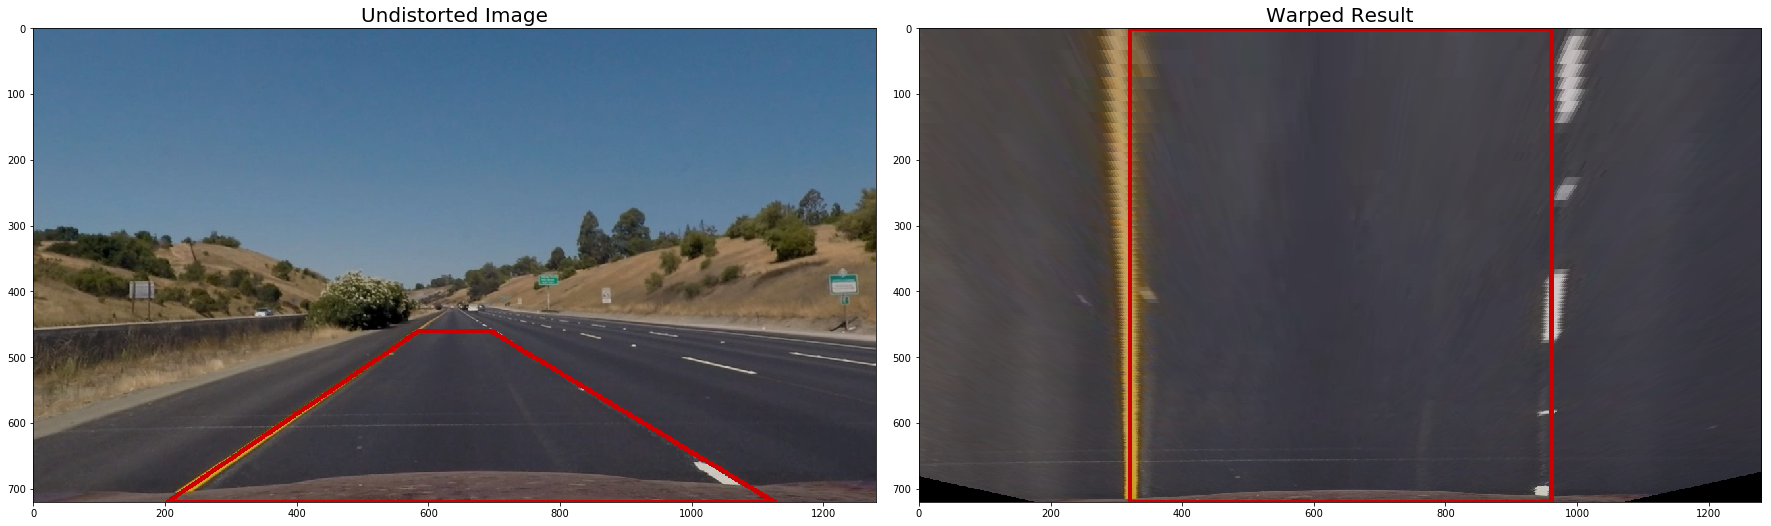

In [7]:
#Diretory of the undistorted image
list_image_Raw=os.listdir("output_images/Raw/")
Output_dir_Bird_Eye=('output_images/Bird/Eye_View')
Output_dir_Bird_Und=('output_images/Bird/Undistorded')

def Draw_original(img):

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)    
    draw_lines_original(img)
    return line_img

def Draw_warped(img):

    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)    
    draw_lines_warped(img)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):

    return cv2.addWeighted(initial_img, α, img, β, γ)

def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def draw_lines_original(img,color=[255, 0, 0], lineThickness=5):

    global src
    cv2.line(img, (src[0][0], src[0][1]), (src[1][0], src[1][1]), (255,0,0), lineThickness)
    cv2.line(img, (src[1][0], src[1][1]), (src[2][0], src[2][1]), (255,0,0), lineThickness)
    cv2.line(img, (src[2][0], src[2][1]), (src[3][0], src[3][1]), (255,0,0), lineThickness)
    cv2.line(img, (src[0][0], src[0][1]), (src[3][0], src[3][1]), (255,0,0), lineThickness)

def draw_lines_warped(img,color=[255, 0, 0], lineThickness=5):

    global dst
    cv2.line(img, (dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), (255,0,0), lineThickness)
    cv2.line(img, (dst[1][0], dst[1][1]), (dst[2][0], dst[2][1]), (255,0,0), lineThickness)
    cv2.line(img, (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1]), (255,0,0), lineThickness)
    cv2.line(img, (dst[0][0], dst[0][1]), (dst[3][0], dst[3][1]), (255,0,0), lineThickness)
        

        
for fname in list_image_Raw[:8]:
    img = mpimg.imread('output_images/Raw/' + fname)
    img_size=[img.shape[1],img.shape[0]]
    
    # Source point
    src = np.float32(
        [[(img_size[0] // 2) - 55, img_size[1] // 2 + 100],
        [((img_size[0] // 6) - 10), img_size[1]],
        [(img_size[0] * 5 // 6) + 60, img_size[1]],
        [(img_size[0] // 2 + 55), img_size[1] // 2 + 100]])

    #destination point
    dst = np.float32(
        [[(img_size[0] // 4), 0],
        [(img_size[0] // 4), img_size[1]],
        [(img_size[0] * 3 // 4), img_size[1]],
        [(img_size[0] * 3 // 4), 0]])
    
    img_warped = warper(img,src,dst)
    Drawing=Draw_warped(img_warped)
    Drawing_Und=Draw_original(img)
    Eye=weighted_img(Drawing,img_warped)
    Undistorded=weighted_img(Drawing_Und,img)
    cv2.imwrite(os.path.join(Output_dir_Bird_Eye,fname),cv2.cvtColor(Eye, cv2.COLOR_RGB2BGR)) 
    cv2.imwrite(os.path.join(Output_dir_Bird_Und,fname),cv2.cvtColor(Undistorded, cv2.COLOR_RGB2BGR)) 
    
## Exemple 

img = mpimg.imread('output_images/Raw/straight_lines1.jpg')
img_size=[img.shape[1],img.shape[0]]
# Source point
src = np.float32(
        [[(img_size[0] // 2) - 55, img_size[1] // 2 + 100],
        [((img_size[0] // 6) - 10), img_size[1]],
        [(img_size[0] * 5 // 6) + 60, img_size[1]],
        [(img_size[0] // 2 + 55), img_size[1] // 2 + 100]])

    #destination point
dst = np.float32(
        [[(img_size[0] // 4), 0],
        [(img_size[0] // 4), img_size[1]],
        [(img_size[0] * 3 // 4), img_size[1]],
        [(img_size[0] * 3 // 4), 0]])
img_warped = warper(img,src,dst)
Eye_View=Draw_warped(img_warped)
Undistorded=Draw_original(img)
Combo_1=weighted_img(Drawing,img_warped)
Combo_2=weighted_img(Drawing_Und,img)

g, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
g.tight_layout()
ax1.imshow(Combo_2)
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(Combo_1)
ax2.set_title('Warped Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
pickle.dump(src, open( "src.p", "wb" ))
pickle.dump(dst, open( "dst.p", "wb" ))

## Perspective transform ("birds-eye view") + Thresholded

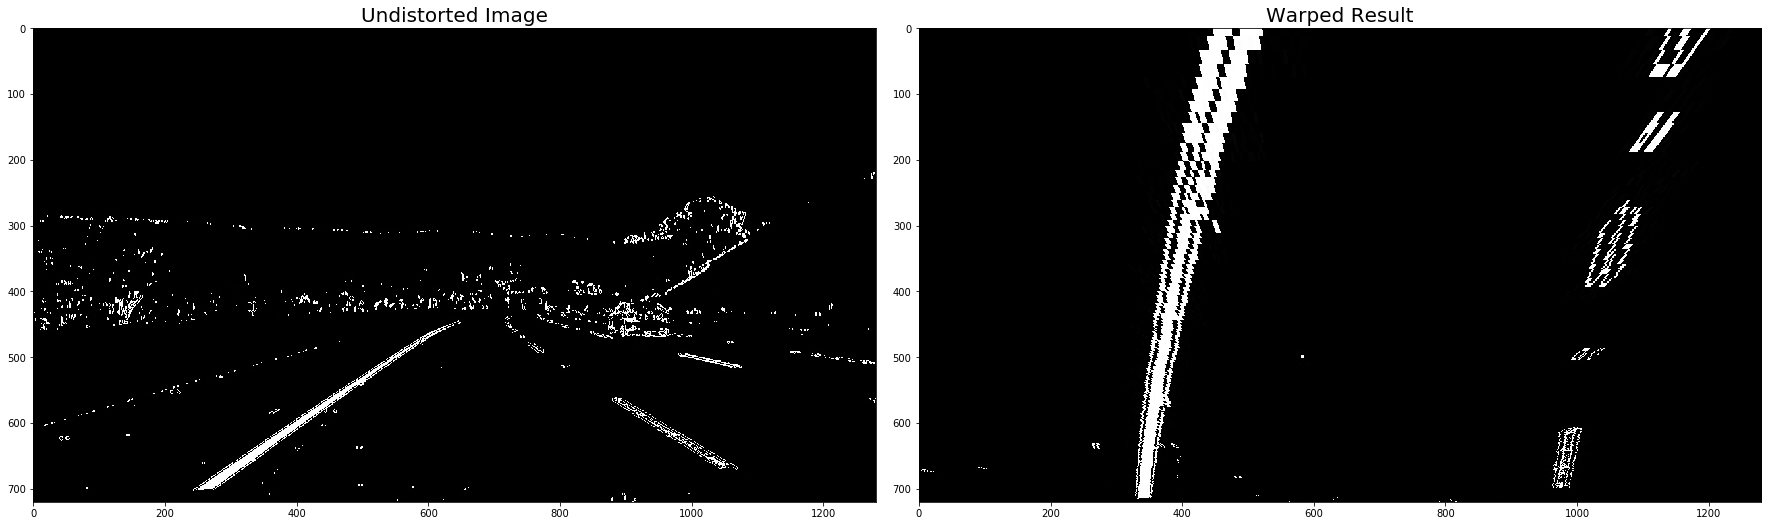

In [9]:
#Diretory of the undistorted image
list_image_Raw=os.listdir("output_images/Thresholded/")
Output_dir_Bird_Eye_T=('output_images/Thresholded_Bird/Eye_View')
 
for fname in list_image_Raw[:8]:
    global src
    global dst
    img = mpimg.imread('output_images/Thresholded/' + fname)
    img_size=[img.shape[1],img.shape[0]]
    img_warped = warper(img,src,dst)
    cv2.imwrite(os.path.join(Output_dir_Bird_Eye_T,fname),img_warped) 
    
## Exemple 

img = mpimg.imread('output_images/Thresholded/test3.jpg')
img_size=[img.shape[1],img.shape[0]]
img_warped = warper(img,src,dst)

g, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
g.tight_layout()
ax1.imshow(img,cmap='gray')
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(img_warped,cmap='gray')
ax2.set_title('Warped Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary

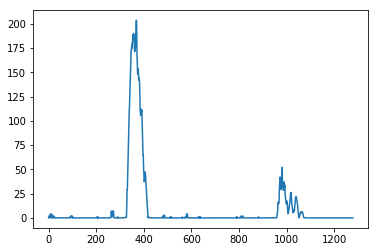

In [10]:
# Load image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('output_images/Thresholded_Bird/Eye_View/test3.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)
# Visualize the resulting histogram
plt.plot(histogram)

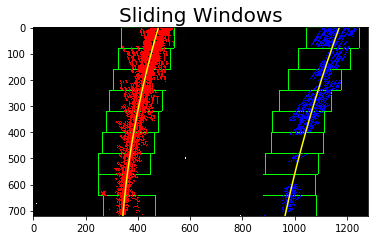

In [11]:
# Load our image

list_image_Eye_View_Bin=os.listdir("output_images/Thresholded_Bird/Eye_View/")
Output_dir_Bird_Eye_Bin=('output_images/Sliding_Windows')

#binary_warped = mpimg.imread('warped_example.jpg')

def find_lane_pixels(binary_warped):
    #out_img=[]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

## Exemple

binary_warped = mpimg.imread('output_images/Thresholded_Bird/Eye_View/test3.jpg')
out_img = fit_polynomial(binary_warped)
plt.title('Sliding Windows', fontsize=20)
plt.imshow(out_img)

#for fname in list_image_Eye_View_Bin:
#    binary_warped = mpimg.imread('output_images/Thresholded_Bird/Eye_View/' + fname)
#    out_img = fit_polynomial(binary_warped)
#    cv2.imwrite(os.path.join(Output_dir_Bird_Eye_Bin,fname),out_img) 

## Search from prior

In [12]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    

    return left_fitx, right_fitx, ploty

# Test on a image

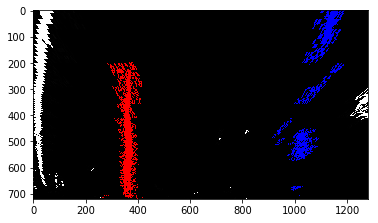

In [29]:
# Load the image
binary_warped = mpimg.imread('output_images/Thresholded_Bird/Eye_View/test4.jpg')
undist=mpimg.imread('test_images/test4.jpg')
img_size=[undist.shape[1],undist.shape[0]]

# Source point
src = np.float32(
        [[(img_size[0] // 2) - 55, img_size[1] // 2 + 100],
        [((img_size[0] // 6) - 10), img_size[1]],
        [(img_size[0] * 5 // 6) + 60, img_size[1]],
        [(img_size[0] // 2 + 55), img_size[1] // 2 + 100]])

    #destination point
dst = np.float32(
        [[(img_size[0] // 4), 0],
        [(img_size[0] // 4), img_size[1]],
        [(img_size[0] * 3 // 4), img_size[1]],
        [(img_size[0] * 3 // 4), 0]])

def find_lane_pixels(binary_warped):
    #out_img=[]
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit

## Exemple
out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)

## Determine the curvature of the lane and vehicle position with respect to center.

In [14]:
def fit_polynomial_modif_real(binary_warped,ym_per_pix,xm_per_pix):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    return plot_y,left_fit_cr,right_fit_cr

def measure_curvature_real(plot_y,left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(plot_y)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

plot_y,left_fit_cr,right_fit_cr = fit_polynomial_modif_real(binary_warped,ym_per_pix,xm_per_pix)
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(plot_y,left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
curverad=(left_curverad + right_curverad)/2

Mean=(left_fitx[0]+right_fitx[0])/2
Mean_image=img_size[1]
Pix_2_Real=abs(Mean-Mean_image)*xm_per_pix

#print(left_curverad, 'm', right_curverad, 'm')

## Warp the detected lane boundaries back onto the original image.

True

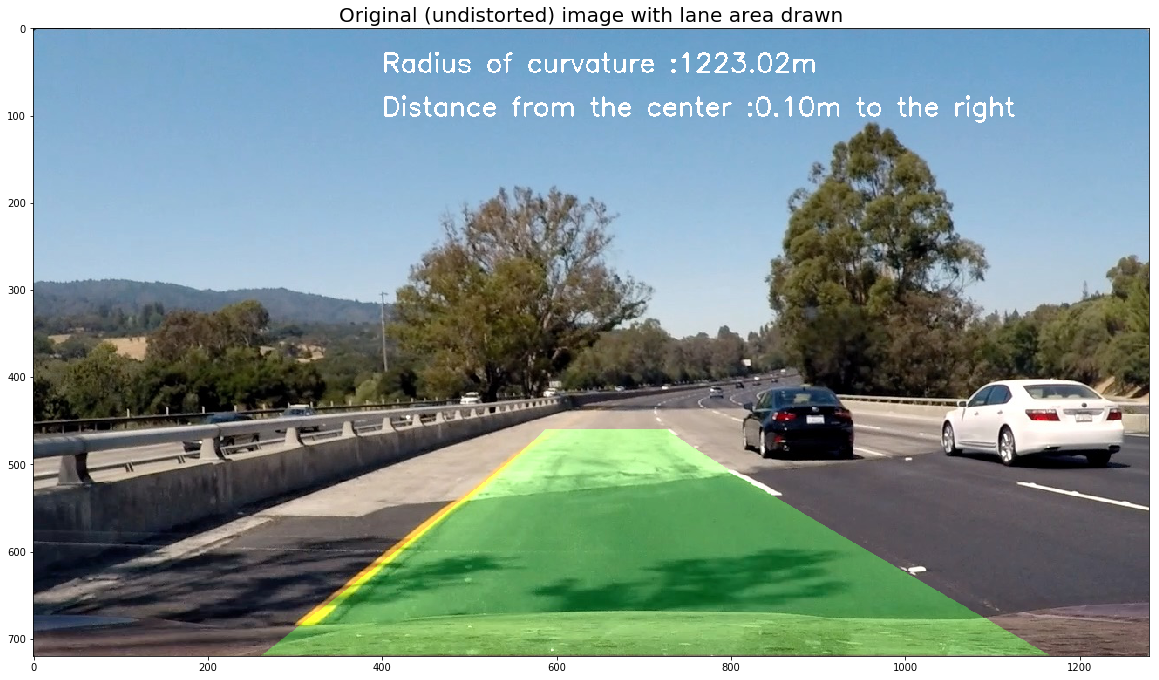

In [38]:
Minv = cv2.getPerspectiveTransform(dst, src)

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

# Write some Text

font1                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText1 = (400,50)
fontScale1              = 1
fontColor1              = (255,255,255)
lineType1               = 2

font2                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText2 = (400,100)
fontScale2              = 1
fontColor2              = (255,255,255)
lineType2               = 2

cv2.putText(result,'Radius of curvature :'+ str("%.2f" % round(curverad,2)) + 'm',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
if Mean >= Mean_image: 
    cv2.putText(result,'Distance from the center :'+ str("%.2f" % round(Pix_2_Real,2)) + 'm to the right',bottomLeftCornerOfText2,font2,fontScale2,fontColor2,lineType2)
else:
    cv2.putText(result,'Distance from the center :'+ str("%.2f" % round(Pix_2_Real,2)) + 'm to the left',bottomLeftCornerOfText2,font2,fontScale2,fontColor2,lineType2)
plt.figure(figsize=(20,20))
plt.title('Original (undistorted) image with lane area drawn', fontsize=20)
plt.imshow(result)

cv2.imwrite('output_images/Final_Result/test4.jpg',cv2.cvtColor(result, cv2.COLOR_RGB2BGR)) 

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [17]:
compteur=0
def process_image(image):
    global compteur
    src = pickle.load( open( "src.p", "rb" ) )
    dst = pickle.load( open( "dst.p", "rb" ) )
    imgpoints = pickle.load( open( "imgpoints.p", "rb" ) )
    objpoints = pickle.load( open( "objpoints.p", "rb" ) )
    
# Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension)

## Distortion correction to raw images.

    undistorded = cal_undistort(image, objpoints, imgpoints)
## Threshold Image
## Parameters 
    S_min_max=[190,255]
    Sx_min_max=[30,80]
    sobel_kernel=5

    Threshold=S_and_Sx_threshold(undistorded,S_min_max,Sx_min_max,sobel_kernel)

## Bird eye view

    img_warped = warper(Threshold,src,dst)

# compteur
    
    if compteur==0:
        ## Polynomial fit
        out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(img_warped)
        # Run image through the pipeline
        # Note that in your project, you'll also want to feed in the previous fits
    else:
        left_fit = pickle.load( open( "left_fit.p", "rb" ) )
        right_fit = pickle.load( open( "right_fit.p", "rb" ) )
        left_fitx, right_fitx, ploty = search_around_poly(img_warped,left_fit,right_fit)

## Curvature

    plot_y,left_fit_cr,right_fit_cr = fit_polynomial_modif_real(img_warped,ym_per_pix,xm_per_pix)
    left_curverad, right_curverad = measure_curvature_real(plot_y,left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
    curverad=(left_curverad + right_curverad)/2
    Mean=(left_fitx[0]+right_fitx[0])/2
    Mean_image=img_size[1]
    Pix_2_Real=abs(Mean-Mean_image)*xm_per_pix

## Unwrap to original image

    Minv = cv2.getPerspectiveTransform(dst, src)

# Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
# Save point

    pickle.dump(left_fit, open( "left_fit.p", "wb" ))
    pickle.dump(right_fit, open( "right_fit.p", "wb" ))
    compteur = compteur +1

# Write some Text

    font1                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText1 = (400,50)
    fontScale1              = 1
    fontColor1              = (255,255,255)
    lineType1               = 2

    font2                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText2 = (400,100)
    fontScale2              = 1
    fontColor2              = (255,255,255)
    lineType2               = 2

    cv2.putText(result,'Radius of curvature :'+ str("%.2f" % round(curverad,2)) + 'm',bottomLeftCornerOfText1,font1,fontScale1,fontColor1,lineType1)
    if Mean >= Mean_image: 
        cv2.putText(result,'Distance from the center :'+ str("%.2f" % round(Pix_2_Real,2)) + 'm to the right',bottomLeftCornerOfText2,font2,fontScale2,fontColor2,lineType2)
    else:
        cv2.putText(result,'Distance from the center :'+ str("%.2f" % round(Pix_2_Real,2)) + 'm to the left',bottomLeftCornerOfText2,font2,fontScale2,fontColor2,lineType2)
    
    return result

In [18]:
Project_output = 'Test_Video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip1 = VideoFileClip("project_video.mp4")
Project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time Project_clip.write_videofile(Project_output, audio=False)

[MoviePy] >>>> Building video Test_Video/project_video.mp4
[MoviePy] Writing video Test_Video/project_video.mp4


100%|█████████▉| 1260/1261 [10:11<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Test_Video/project_video.mp4 

CPU times: user 7min 42s, sys: 15 s, total: 7min 57s
Wall time: 10min 15s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(Project_output))

# Challenge Video

In [24]:
challenge_output = 'Test_Video/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video Test_Video/challenge_video.mp4
[MoviePy] Writing video Test_Video/challenge_video.mp4


100%|██████████| 485/485 [03:50<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Test_Video/challenge_video.mp4 

CPU times: user 2min 53s, sys: 7.37 s, total: 3min
Wall time: 3min 53s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))